# General functioning

The algorithm is divided into two main parts:

1. gap_dataset.py:
    - In this file we prepare the data for the gapfilling algorithm. 
    - We slice a specific dimensions (e.g. area and time range) from the data cube with the values for the specified variable.
    - If requested artificial gaps can be inserted in the array. 
2. gap_filling.py:
    - In this file the gaps created in the GapDataset class will be filled.
    - The Gapfiller class builds for each missing value an own model.

Each time 'GapDataset(ds, ds_name, dimensions, artificial_gaps, actual_matrix).get_data()' is executed, a new directory is created in 'application_results/'.
Inside this directory the class "GapDataset" creates the following datasets:
'cube.zarr' stores the sliced data with the corresponding values of the specified variable for each pixel.
'actual.zarr' stores the actual data array where the gaps need to be filled.
If artificial gaps should be created, the arrays with the artificial gaps are stored in 'GapImitation/' with different gap sizes in each array.
'extra_matrix_xy.zarr' has extra data e.g. corresponding land cover class values for each value in the matrix. The extra matrix can be used as a predictor configuration for the gap filling process.

In the second step the execution of 'Gapfiller(ds_name, learning_function, hyperparameters, predictor).gapfill()' creates the subdirectory 'Results/'.
For each gap the values will be estimated. 
The average difference of the estimated value and the actual value (only available at artificial gaps) of each gap will be calculated as well as the mean absolute error based on cross validation. 
The filled arrays will be stored in 'Results/' subdirectory.


## Data

The currently used data is from the [xcube](https://xcube.readthedocs.io/en/latest/installation.html) dataset.
For more information about the xcube data, follow the link.  

## Parameters

### GapDataset class

#### ds
- data cube (type: xarray.DataArray) with gaps e.g. a EarthSystemDataCubeS3

#### ds_name
- specify the name of the dataset -> a new directory with this name will be created in 'application_results/' - if a directory with this name already exists, it will be overwritten
- DEFAULT: 'Test123'
- other options: 
    - free choice - no restriction for the naming convention

#### dimensions
- dimensions of the data cube that will be sliced e.g. lat, lon, times
- DEFAULT: dimensions = {'lat': (54, 48), 'lon': (6, 15), 'times': (datetime.date(2008, 11, 1), datetime.date(2008, 12, 31))}
- other options:
    - free choice depending on the data cube

#### artificial_gaps
- list of artificial gaps that can be created -> the gapfilling algorithm performs on artificial gaps if they are stated; if this parameter is None, it estimates real gaps in the matrix
- DEFAULT: None
- other options
    - free choice - total range for each element from 0-1, e.g. [0.001, 0.01, 0.1, 0.25, 0.5, 0.75]

#### actual_matrix
- specifies the actual data matrix (str or datetime.date) where the gaps should be filled; if the date should be random, select 'Random'
- DEFAULT: 'Random'
- other options
    - free choice (datetime.date) 

### Gapfiller class

#### ds_name
- same as the name for the GapDataset class -> otherwise no directory will be found and the gapfilling algorithm cannot perform
- DEFAULT: 'Test123'
- other options: 
    - free choice - but it should have the name of an existing directory in 'application_results/'
 
#### learning_function
- select the learning function to train the model; currently just SupportVectorRegression possible, but you can adapt/inherit from this class to add other learning functions
- DEFAULT: 'SVR'

#### hyperparameters
- strategies for configuring hyperparameters
- DEFAULT: 'RandomGridSearch' - random grid search
- other options:
    - 'FullGridSearch' - full grid search
    - 'Custom' - custom settings according to the scikit-learn syntax that can be changed in the 'learning_function'-method - current settings: **params = {'kernel': 'linear', 'gamma': 'scale', 'C': 1000, 'epsilon': 1}

#### predictor
- strategies for selecting predictors
- DEFAULT: 'RandomPoints' - randomly selected 100 points in the matrix - if less than 100 points with values in the metric, all non-gap values will be used as predictors; if less than 50 pixel have known values, interpolation is used to estimate the gaps
- other options:
    - 'AllPoints' - all known values -> runtime can be very big
    - 'lccs_class' - the 40 closest pixels from the same land cover class (e.g. mixed forest) as the gap will be used as predictors - if there are less than 40 pixels from the same land cover class, the strategy changes to 'RandomPoints'.
    - you can add other predictors if you like -> see predictors.py

## Observations and recommendations (so far)

In terms of runtime and accuracy, 'RandomGridSearch' works best for configuring hyperparameters and 'RandomPoints' or another physical parameter (depending on the cube e.g. lccs_class) for selecting predictors.
Since a model is created for each gap pixel, the runtime increases linearly proportional to the number of gaps, while the accuracy deteriorates only slightly.
For the number of training samples, no more than 40-100 arrays need to be cut from the respective area - since the recordings in the data cube occur every 8 days and the runtime increases with the number of training samples, 1-2 years could be sufficient as a time period depending on the data cube. 

## Example with added artificial gaps

In [1]:
import datetime
from xcube.core.store import new_data_store
from ml4xcube.gapfilling.gap_filling import Gapfiller
from ml4xcube.gapfilling.gap_dataset import GapDataset
from ml4xcube.gapfilling.helper.predictors import HelpingPredictor

In [13]:
# Directory name
ds_name = 'GermanyNB_artificial_gaps'
# Variable that will be estimated e.g. 'land_surface_temperature' or 'air_temperature_2m'
variable = 'land_surface_temperature'
# Dimension values of the datacube, e.g. Latitude and longitude of the area and time.
# Global range: lat = (90, -90), lon = (-180, 180)
dimensions = {
    'time': (datetime.date(2008, 1, 1), datetime.date(2008, 12, 31)),
    'lat': (54, 48),
    'lon': (6, 15), 
}
# List of artificial gaps that will be created
# if no artificial gaps should be created, the gapfilling algorithms will perform on real gaps
# options: None or list of artificial gap sizes e.g. [0.001, 0.01, 0.1, 0.25, 0.5, 0.75]
artificial_gaps = [0.01, 0.1, 0.25, 0.5, 0.75]
# Speficy whether the actual matrix will be chosen random or is from a specific file.
# Options: 'Random' or datetime.date of the specific file e.g. datetime.date(2008, 12, 14) or other dimensional parameter value
actual_matrix = datetime.date(2008, 9, 1) 

# 2 ways for loading the data cube
# 1) open a local data cube: ds = xr.open_zarr("path/to/cube.zarr")[variable]
# 2) get the data cube from the store
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset = data_store.open_data('esdc-8d-0.083deg-184x270x270-2.1.1.zarr')
# Select the variable of interest from the dataset
ds = dataset[variable]

In [5]:
# Get the data from the data cube
GapDataset(ds, ds_name, dimensions, artificial_gaps, actual_matrix).get_data()

GermanyNB_artificial_gaps {'time': 46, 'lat': 72, 'lon': 108}
Extra predictor data matrix for has lccs_class been created.
Actual matrix: 2008-09-01
Real gap size:  9 %
5 array(s) with the following gaps were created: 1.0%, 10.0%, 25.0%, 50.0%, 75.0%
These arrays are saved in //home/scadspc14/repos/ML-Toolkits/application_results/GermanyNB_artificial_gaps/
Runtime: 1.02


In [17]:
# Choose hyperparameter settings. Options: 'RandomGridSearch' | 'FullGridSearch' | 'Custom'
hyperparameters = "RandomGridSearch"
# Choose the predictor type. Options: ''AllPoints' | 'RandomPoints' | 'lccs_class' or other extra matrix predictors
predictor = "RandomPoints"
# Choose learning function: Options (can be supplemented): 'SVR' for SupportVectorRegression
learning_function = "SVR"

In [9]:
# Perform the gap filling using the chosen settings
Gapfiller(ds_name=ds_name, learning_function=learning_function, hyperparameters=hyperparameters, predictor=predictor).gapfill()

Fill the gaps of 5 array(s) with the following gap size: 1.0%, 10.0%, 25.0%, 50.0%, 75.0%
The array(s) are saved in: //home/scadspc14/repos/ML-Toolkits/application_results/GermanyNB_artificial_gaps/
Original array: 2008-09-01 

gap size: 1.0 % -> 77 pixel 
training pictures: 45
100%|████████████████████| 78/78 [00:03<00:00, 24.15it/s]
MAE actual: 1.686
MAE cross validation: Could not be calculated as interpolation was partly used.
runtime: 3.50 seconds 

gap size: 10.0 % -> 777 pixel 
training pictures: 45
100%|████████████████████| 778/778 [00:31<00:00, 24.38it/s]
MAE actual: 1.751
MAE cross validation: Could not be calculated as interpolation was partly used.
runtime: 34.33 seconds 

gap size: 25.0 % -> 1944 pixel 
training pictures: 45
100%|████████████████████| 1944/1944 [01:23<00:00, 23.32it/s]
MAE actual: 1.704
MAE cross validation: Could not be calculated as interpolation was partly used.
runtime: 89.14 seconds 

gap size: 50.0 % -> 3888 pixel 
training pictures: 45
100%|███████

### Same example but with other predictors

In case you want to use another physical parameter as an predictor, you can make use of ```predictors.py```.

The python file gets global predictor data e.g. land cover classification data for the corresponding dimensions as the examined data cube (e.g. latitude and longitude coordinates). 
The results will be stored in a '.zarr' dataset.
During the area slicing process the zarr dataset is the source for the data in order to be used as predictors.
Once the global zarr dataset is executed, the dataset can be used for all gapfilling example applications.
This file can be helpful to extract other variables as predictors and match the coordinates.

You only need to execute this once for a data cube and a specific predictor. Afterwards you can use the ```global_xy.zarr``` dataset without executing this file again.

In [3]:
# Variables same as above
ds_name = 'GermanyNB_LCC'
variable = 'land_surface_temperature'
dimensions = {
    'time': (datetime.date(2008, 1, 1), datetime.date(2008, 12, 31)),
    'lat': (54, 48),
    'lon': (6, 15), 
}
artificial_gaps = [0.01, 0.1, 0.25, 0.5, 0.75]
actual_matrix = datetime.date(2008, 9, 1) 

# Initializing the xcube datastore for s3 object storage and open the dataset of the variable you want to estimate (same as above)
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset = data_store.open_data('esdc-8d-0.083deg-184x270x270-2.1.1.zarr')
ds_variable = dataset[variable]

# Initializing the xcube datastore for s3 object storage and open the dataset of the predictor variable
predictor = 'lccs_class'
data_store = new_data_store("s3", root="deep-esdl-public", storage_options=dict(anon=True))
dataset = data_store.open_data('LC-1x2160x2160-1.0.0.levels')
ds_predictor = dataset.get_dataset(0)[predictor]

# Get global predictor data for the corresponding data cube - Remember you only have to execute this once. 
# Afterwards you can always rely on the resulting zarr dataset if you are dealing with the same cube and predictor variable
HelpingPredictor(ds_variable, ds_predictor, predictor).get_predictor_data()
# Before performing the gapfilling you still have to execute GapDataset first as it loads the predictor data
GapDataset(ds_variable, ds_name, dimensions, artificial_gaps, actual_matrix).get_data()

GermanyNB_LCC {'time': 46, 'lat': 72, 'lon': 108}
Extra predictor data matrix for has lccs_class been created.
Actual matrix: 2008-09-01
Real gap size:  9 %
5 array(s) with the following gaps were created: 1.0%, 10.0%, 25.0%, 50.0%, 75.0%
These arrays are saved in //Users/marco/repos/ML-Toolkits/application_results/GermanyNB_LCC/
Runtime: 3.39


In [4]:
# Perform the gap filling using the chosen settings
Gapfiller(ds_name=ds_name, learning_function="SVR", hyperparameters="RandomGridSearch", predictor=predictor).gapfill()

Fill the gaps of 5 array(s) with the following gap size: 1.0%, 10.0%, 25.0%, 50.0%, 75.0%
The array(s) are saved in: //Users/marco/repos/ML-Toolkits/application_results/GermanyNB_LCC/
Original array: 2008-09-01 

gap size: 1.0 % -> 77 pixel 
training pictures: 45
100%|████████████████████| 78/78 [00:01<00:00, 66.59it/s]
MAE actual: 1.084
MAE cross validation: 0.987
runtime: 1.29 seconds 

gap size: 10.0 % -> 777 pixel 
training pictures: 45
100%|████████████████████| 778/778 [00:11<00:00, 65.78it/s]
MAE actual: 1.172
MAE cross validation: 1.096
runtime: 12.89 seconds 

gap size: 25.0 % -> 1944 pixel 
training pictures: 45
100%|████████████████████| 1944/1944 [00:31<00:00, 62.48it/s]
MAE actual: 1.245
MAE cross validation: 1.146
runtime: 33.50 seconds 

gap size: 50.0 % -> 3888 pixel 
training pictures: 45
100%|████████████████████| 3888/3888 [01:00<00:00, 64.15it/s]
MAE actual: 1.299
MAE cross validation: 1.254
runtime: 65.33 seconds 

gap size: 75.0 % -> 5832 pixel 
training pictures:

As you can see the results can be much better if you use suitable physical parameter data as predictors.

## Example without artificial gaps where the algorithm estimates real gaps

In [15]:
# In this example we will use the same xcube array to estimate the real gaps of this example
# We just need to specify a different name to not override the results
ds_name = 'GermanyNB_with_real_gaps'
artificial_gaps = None

GapDataset(ds, ds_name, dimensions, artificial_gaps, actual_matrix).get_data()

GermanyNB_with_real_gaps {'time': 46, 'lat': 72, 'lon': 108}
Extra predictor data matrix for has lccs_class been created.
Actual matrix: 2008-09-01
Real gap size:  9 %
Runtime: 0.79


In [16]:
# Directory name based on the input name in 'GapDataset'
# We will use the same parameter as in the previous example
Gapfiller(ds_name=ds_name, learning_function='SVR', hyperparameters=hyperparameters, predictor=predictor).gapfill()

Fill the gaps of 1 array(s) with the following gap size: 8.7%
The array(s) are saved in: //home/scadspc14/repos/ML-Toolkits/application_results/GermanyNB_with_real_gaps/
Original array: 2008-09-01 

gap size: 8.7 % -> 676 pixel 
training pictures: 45
100%|████████████████████| 678/678 [00:29<00:00, 22.83it/s]
runtime: 29.73 seconds 

The missing values of the gaps are now filled. You can find the results in //home/scadspc14/repos/ML-Toolkits/application_results/GermanyNB_with_real_gaps/Results/


## Visualisation

In [18]:
import os
import numpy as np
import xarray as xr
from ml4xcube.xr_plots import plot_slice

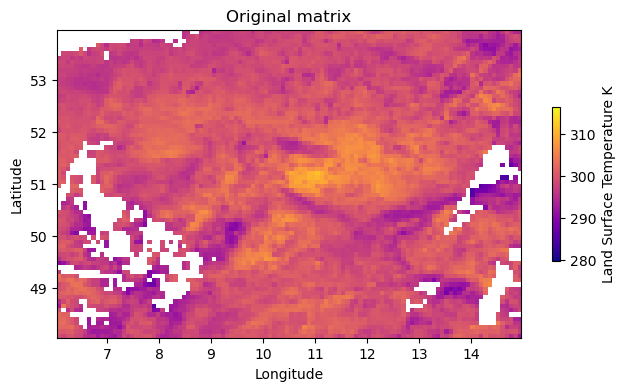

In [19]:
variable = 'land_surface_temperature'
directory = "../application_results/GermanyNB_artificial_gaps/"

xr_slice = xr.open_zarr(directory + "actual.zarr").compute()
masked_array = np.ma.masked_where(xr_slice[variable] == -100, xr_slice[variable])
xr_slice[variable] = (xr_slice[variable].dims, masked_array)

vmin = np.nanmin(masked_array) - 5
vmax = np.nanmax(masked_array) + 5

plot_slice(
    ds= xr_slice,
    var_to_plot = variable,  # replace with your actual variable to plot
    color_map   = 'plasma',
    title       = 'Original matrix',
    label       = 'Land Surface Temperature K',
    vmin        = vmin,      # use calculated vmin
    vmax        = vmax,      # use calculated vmax
    xdim        = 'lon',
    ydim        = 'lat',
    fig_size    = (8,4)
)

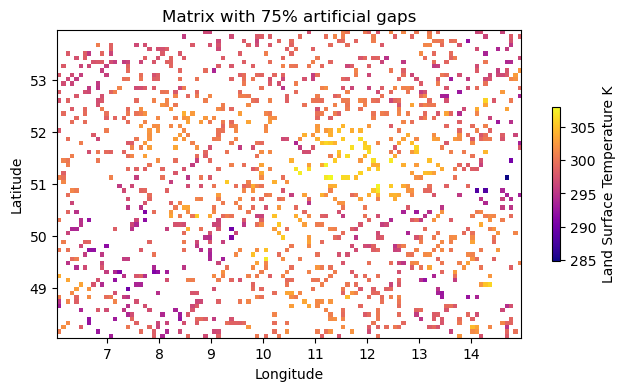

In [20]:
# Load the array with 75% imitated gaps
gap_size = '0.75'
xr_slice = xr.open_zarr(directory + "GapImitation/" + str(actual_matrix) + "_" + gap_size + ".zarr").compute()
masked_array = np.ma.masked_where(xr_slice[variable] == -100, xr_slice[variable])
xr_slice[variable] = (xr_slice[variable].dims, masked_array)

plot_slice(
    ds          = xr_slice,
    var_to_plot = variable,  # replace with your actual variable to plot
    color_map   = 'plasma',
    title       = 'Matrix with 75% artificial gaps',
    label       = 'Land Surface Temperature K',
    xdim        = 'lon',
    ydim        = 'lat',
    fig_size    = (8,4)
)

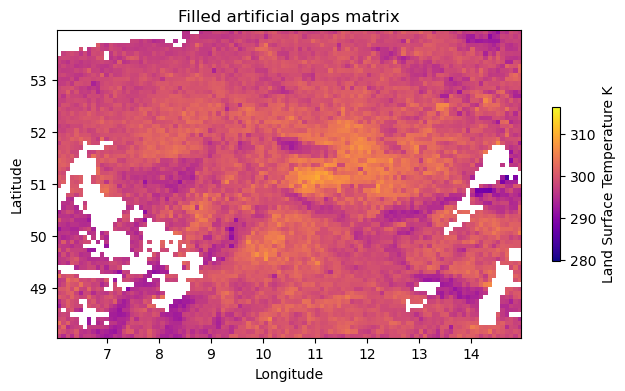

In [21]:
# Load the array with the filled artifical gaps
xr_slice = xr.open_zarr(directory + "Results/" + str(actual_matrix) + "-" + gap_size + ".zarr").compute()
masked_array = np.ma.masked_where(xr_slice["__xarray_dataarray_variable__"] == -100, xr_slice["__xarray_dataarray_variable__"])
xr_slice["__xarray_dataarray_variable__"] = (xr_slice["__xarray_dataarray_variable__"].dims, masked_array)

plot_slice(
    ds= xr_slice,
    var_to_plot = "__xarray_dataarray_variable__",  # replace with your actual variable to plot
    color_map   = 'plasma',
    title       = 'Filled artificial gaps matrix',
    label       = 'Land Surface Temperature K',
    vmin        = vmin,      
    vmax        = vmax,      
    xdim        = 'lon',
    ydim        = 'lat',
    fig_size    = (8,4)
)

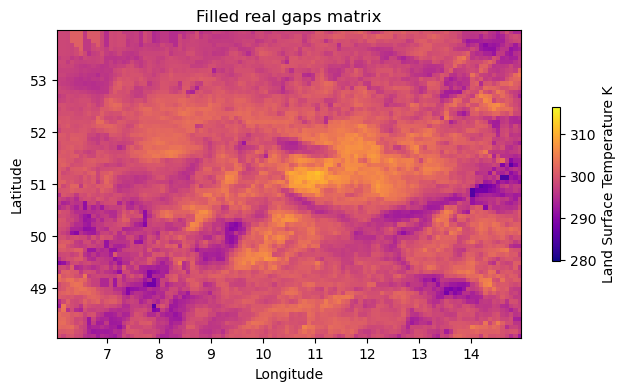

In [22]:
# Load the array with the filled artifical gaps
directory = "../application_results/GermanyNB_with_real_gaps/"

xr_slice = xr.open_zarr(directory + "Results/" + str(actual_matrix) + "-0.087.zarr").compute()
masked_array = np.ma.masked_where(xr_slice["__xarray_dataarray_variable__"] == -100, xr_slice["__xarray_dataarray_variable__"])
xr_slice["__xarray_dataarray_variable__"] = (xr_slice["__xarray_dataarray_variable__"].dims, masked_array)

plot_slice(
    ds= xr_slice,
    var_to_plot = "__xarray_dataarray_variable__",  # replace with your actual variable to plot
    color_map   = 'plasma',
    title       = 'Filled real gaps matrix',
    label       = 'Land Surface Temperature K',
    vmin        = vmin,      
    vmax        = vmax,      
    xdim        = 'lon',
    ydim        = 'lat',
    fig_size    = (8,4)
)

## Visualisation with Lexcube

To visualize the results in a cube you can also use the lexcube library. In this example we fill in the gaps of the same data cube as above for all January data and visualize the results afterwords.

You might have to install it with ```pip install lexcube```.

In [25]:
import os
import lexcube
import numpy as np
import xarray as xr

In [31]:
variable = 'land_surface_temperature'
dimensions = {
    'time': (datetime.date(2008, 1, 1), datetime.date(2008, 12, 31)),
    'lat': (54, 48),
    'lon': (6, 15),
}

data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset = data_store.open_data('esdc-8d-0.083deg-184x270x270-2.1.1.zarr')
ds = dataset[variable]

In [32]:
for time_val in list(ds.time.values):
    # Convert numpy.datetime64 to datetime.date
    actual_matrix = time_val.astype('datetime64[D]').astype(datetime.date)
    # Check if the year is 2008 and the month is January
    if actual_matrix.year == 2008 and actual_matrix.month == 1:
        ds_name = 'GermanyNB_lexcube_' + str(actual_matrix)
        GapDataset(ds, ds_name, dimensions, artificial_gaps=None, actual_matrix=actual_matrix).get_data()
        Gapfiller(ds_name, 'SVR', 'RandomGridSearch', 'lccs_class').gapfill()

GermanyNB_lexcube_2008-01-05 {'time': 46, 'lat': 72, 'lon': 108}
Extra predictor data matrix for has lccs_class been created.
Actual matrix: 2008-01-05
Real gap size:  43 %
Runtime: 1.76
Fill the gaps of 1 array(s) with the following gap size: 42.8%
The array(s) are saved in: //home/scadspc14/repos/ML-Toolkits/application_results/GermanyNB_lexcube_2008-01-05/
Original array: 2008-01-05 

gap size: 42.8 % -> 3328 pixel 
training pictures: 45
100%|████████████████████| 3332/3332 [02:39<00:00, 20.84it/s]
runtime: 159.91 seconds 

The missing values of the gaps are now filled. You can find the results in //home/scadspc14/repos/ML-Toolkits/application_results/GermanyNB_lexcube_2008-01-05/Results/
GermanyNB_lexcube_2008-01-13 {'time': 46, 'lat': 72, 'lon': 108}
Extra predictor data matrix for has lccs_class been created.
Actual matrix: 2008-01-13
Real gap size:  56 %
Runtime: 1.76
Fill the gaps of 1 array(s) with the following gap size: 55.9%
The array(s) are saved in: //home/scadspc14/repos

In [43]:
directory = '../application_results/'
subdirectory = 'GermanyNB_lexcube'
cube_list = []
# Loop through the base directory
for root, dirs, files in os.walk(directory):
    for dir_name in dirs:
    # Check if the directory name starts with ..
        if dir_name.startswith(subdirectory):
            results_path = os.path.join(root, dir_name, "Results")
            # Find all zarr datasets in the "Results" subdirectory
            for file in os.listdir(results_path):
                matrix = xr.open_zarr(os.path.join(results_path, file))['__xarray_dataarray_variable__']
                cube_list.append(matrix)

# Sort the cube_list based on the time value of each DataArray
cube_list_sorted = sorted(cube_list, key=lambda data_array: data_array.time.values)
final_cube = xr.concat(cube_list_sorted, dim='time')

In [44]:
# Visualize the results with lexcube
l = lexcube.Cube3DWidget(final_cube, cmap="thermal_r")
l